In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from collections import Counter
from xgboost import XGBRegressor
from sklearn import svm, metrics
from sklearn.pipeline import Pipeline
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

# 데이터 불러오기
    - 기상 데이터
    - 위경도 데이터

In [4]:
# 데이터 불러오기
df_meta = pd.read_excel('META_관측지점정보_20210521134301.xlsx',header=1)
df_wea = pd.read_excel('combined_all_deltavg.xlsx')

In [5]:
# 위경도 데이터 전처리
df_meta = df_meta.rename(columns={"시작일": "일시"})

df_meta_uq = df_meta.drop_duplicates(['지점'],keep='last')[['지점','위도','경도','노장해발고도(m)']]
dict_meta = df_meta_uq.to_dict('records')

dict_meta_1 = dict()
for dic in dict_meta:
    dict_meta_1[dic['지점']] = [dic['위도'], dic['경도'], dic['노장해발고도(m)']]

# 데이터 전처리
    - 위도/경도/고도 매칭
    - 불필요한 데이터 제거

In [11]:
# 지점별로 위경도 매칭
df_wea['위도'] = df_wea['지점'].apply(lambda x: dict_meta_1[x][0])
df_wea['경도'] = df_wea['지점'].apply(lambda x: dict_meta_1[x][1])
df_wea['고도'] = df_wea['지점'].apply(lambda x: dict_meta_1[x][2])

# 불필요 데이터 제거
df_wea_null = df_wea.dropna(subset=['일 최심신적설(cm)'])
df_wea_null = df_wea_null.loc[df_wea_null['일 최심신적설(cm)']!=0]
df_wea_null['year'] = pd.to_datetime(df_wea_null['일시']).dt.year

# 요청하신 eda 시각화

## plot1

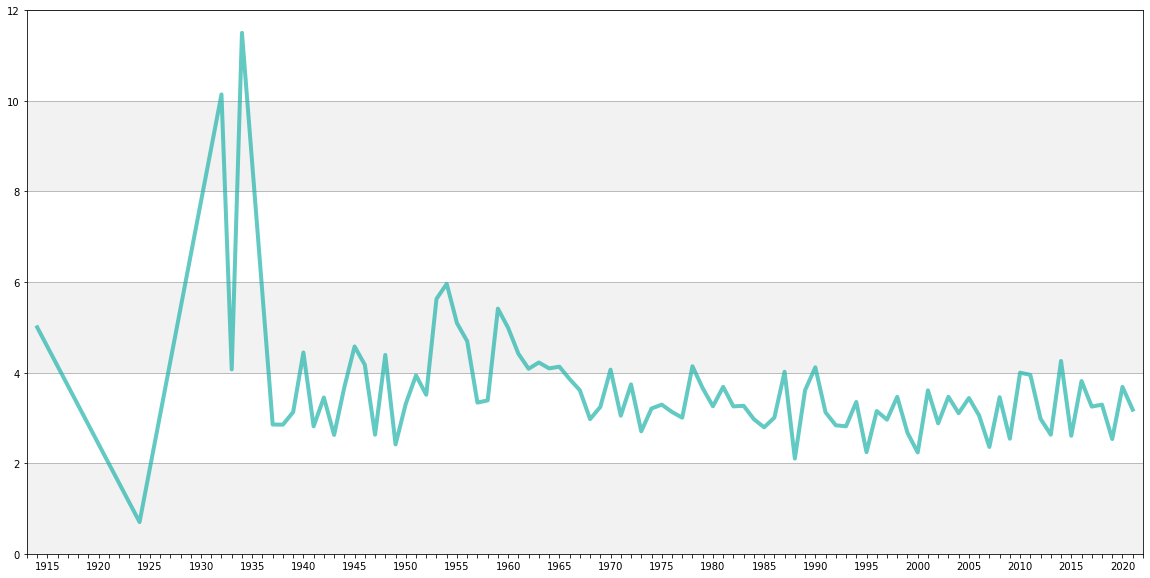

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

df_year_mean = df_wea_null.groupby('year')['일 최심신적설(cm)'].agg('mean').fillna(0)
df_year_mean.to_excel('1번그래프데이터.xlsx')

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_year_mean.index, df_year_mean.values, color='lightseagreen', linewidth=4, alpha=0.7)
ax.xaxis.set_major_locator(mticker.MultipleLocator())

def func(x, pos):
    if not x%5:
        return "{:g}".format(x)
    else:
        return ""
ax.xaxis.set_major_formatter(mticker.FuncFormatter(func))
plt.xlim(1913,2022)
plt.ylim(0,12)
plt.grid(True, axis='y')

yticks, _ = plt.yticks()
for y0, y1 in zip(yticks[::2], yticks[1::2]):
    plt.axhspan(y0, y1, color='gray', alpha=0.1, zorder=0)
plt.yticks(yticks)

plt.show()


## plot2

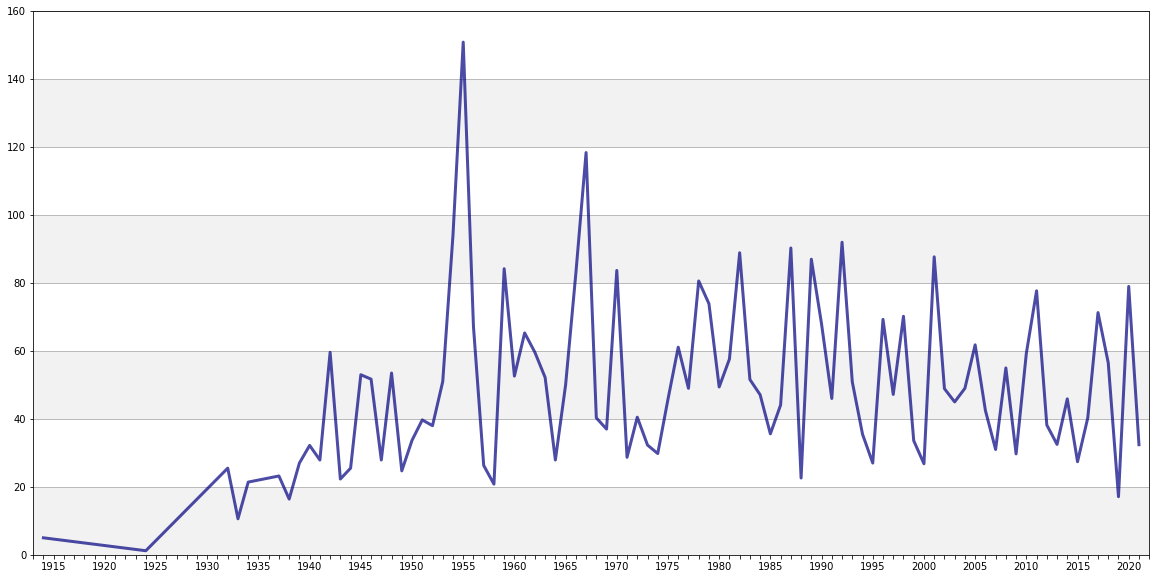

In [ ]:
df_year_max = df_wea_null.groupby('year')['일 최심신적설(cm)'].agg('max').fillna(0)
df_year_max.to_excel('2번그래프데이터.xlsx')

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_year_max.index, df_year_max.values, color='navy', linewidth=3, alpha=0.7)

ax.xaxis.set_major_locator(mticker.MultipleLocator())

def func(x, pos):
    if not x%5:
        return "{:g}".format(x)
    else:
        return ""
ax.xaxis.set_major_formatter(mticker.FuncFormatter(func))
plt.xlim(1913,2022)
plt.ylim(0,160)
plt.grid(True, axis='y')

yticks, _ = plt.yticks()
for y0, y1 in zip(yticks[::2], yticks[1::2]):
    plt.axhspan(y0, y1, color='gray', alpha=0.1, zorder=0)
plt.yticks(yticks)

plt.show()


## plot3

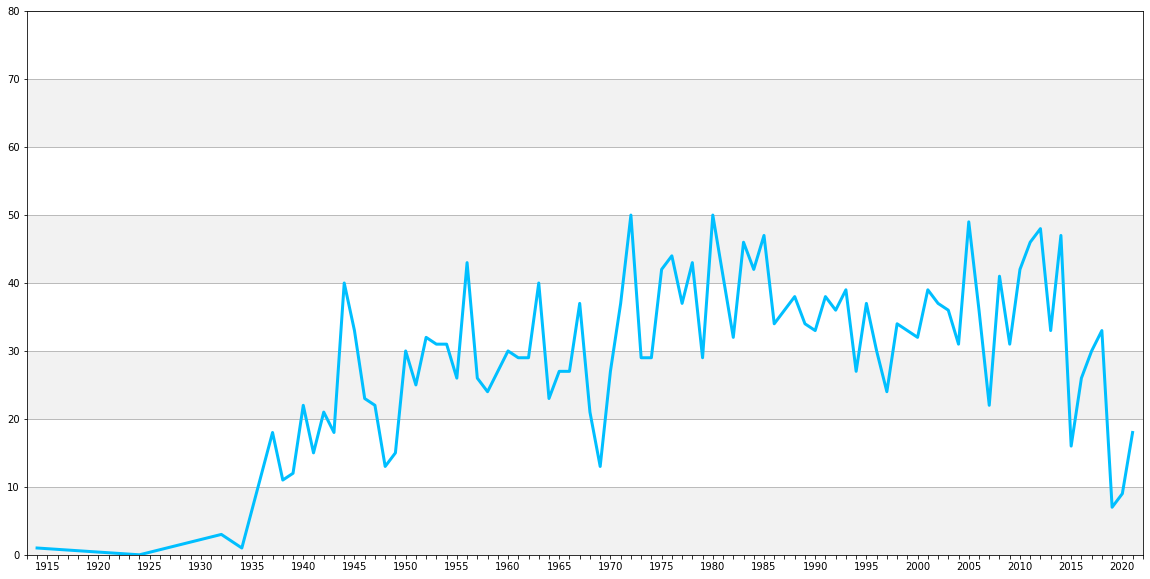

In [ ]:
def calculate_snow(x):
    result = 0
    for i in x:
        if i >=5:
            result = 1
            break
        else:
            pass
    return result
    
def calculate_bigsnow(x):
    result = 0
    for i in x:
        if i >=20:
            result = 1
            break
        else:
            pass
    return result

df_year_bigsnow = df_wea_null.groupby(['일시'])['일 최심신적설(cm)'].apply(list)
df_year_bigsnow_1 = df_year_bigsnow.reset_index()
df_year_bigsnow_1['year'] = pd.to_datetime(df_year_bigsnow_1['일시']).dt.year

df_year_bigsnow_1['대설여부'] = df_year_bigsnow_1['일 최심신적설(cm)'].apply(lambda x: calculate_bigsnow(x)).values
df_year_bigsnow_1['적설여부'] = df_year_bigsnow_1['일 최심신적설(cm)'].apply(lambda x: calculate_snow(x)).values

df_snow_big = df_year_bigsnow_1.groupby('year')['대설여부'].sum()
df_snow = df_year_bigsnow_1.groupby('year')['적설여부'].sum()

df_snow.to_excel('3번그래프데이터.xlsx')
df_snow_big.to_excel('4번그래프데이터.xlsx')

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_snow.index, df_snow.values, color='deepskyblue', linewidth=3, alpha=1)

ax.xaxis.set_major_locator(mticker.MultipleLocator())

def func(x, pos):
    if not x%5:
        return "{:g}".format(x)
    else:
        return ""
ax.xaxis.set_major_formatter(mticker.FuncFormatter(func))
plt.xlim(1913,2022)
plt.ylim(0,80)
plt.grid(True, axis='y')

yticks, _ = plt.yticks()
for y0, y1 in zip(yticks[::2], yticks[1::2]):
    plt.axhspan(y0, y1, color='gray', alpha=0.1, zorder=0)
plt.yticks(yticks)

plt.show()



## plot4

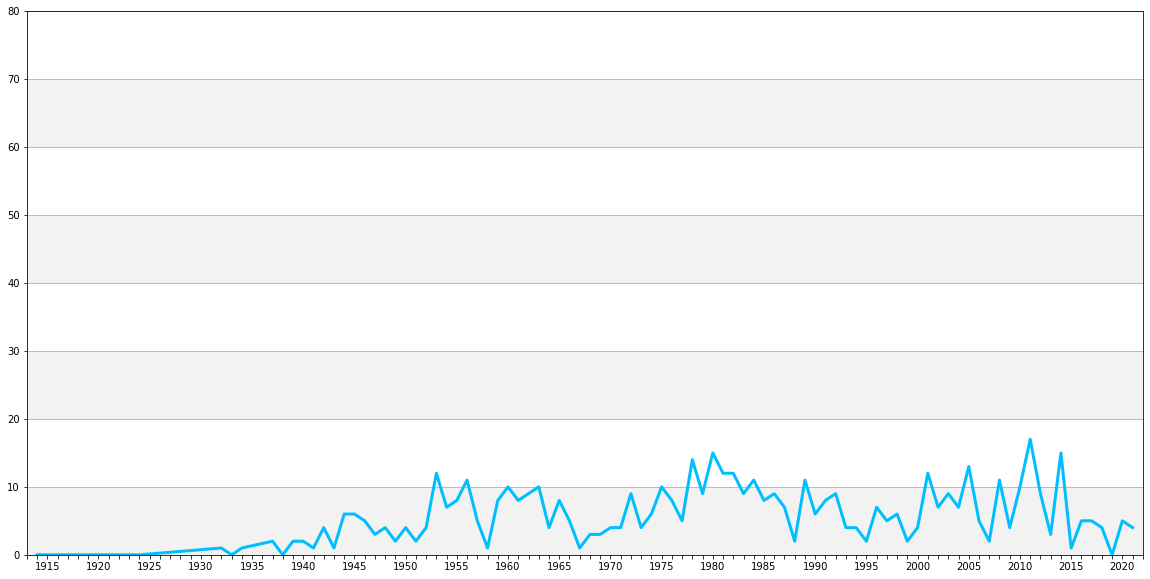

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_snow_big.index, df_snow_big.values, color='deepskyblue', linewidth=3, alpha=1)

ax.xaxis.set_major_locator(mticker.MultipleLocator())

def func(x, pos):
    if not x%5:
        return "{:g}".format(x)
    else:
        return ""
ax.xaxis.set_major_formatter(mticker.FuncFormatter(func))
plt.xlim(1913,2022)
plt.ylim(0,80)
plt.grid(True, axis='y')

yticks, _ = plt.yticks()
for y0, y1 in zip(yticks[::2], yticks[1::2]):
    plt.axhspan(y0, y1, color='gray', alpha=0.1, zorder=0)
plt.yticks(yticks)

plt.show()


